[             單位名稱            買賣差額        日期
0       自營商(自行買賣)   1,316,827,555  20250730
1         自營商(避險)   4,056,939,563  20250730
2              投信   1,437,205,201  20250730
3  外資及陸資(不含外資自營商)  14,112,204,090  20250730
4           外資自營商               0  20250730
5              合計  20,923,176,409  20250730,              單位名稱            買賣差額        日期
0       自營商(自行買賣)   2,796,495,944  20250731
1         自營商(避險)   5,602,641,455  20250731
2              投信      17,825,528  20250731
3  外資及陸資(不含外資自營商)   9,388,571,808  20250731
4           外資自營商               0  20250731
5              合計  17,805,534,735  20250731,              單位名稱            買賣差額        日期
0       自營商(自行買賣)     961,593,581  20250801
1         自營商(避險)    -589,718,990  20250801
2              投信     800,724,259  20250801
3  外資及陸資(不含外資自營商)  -7,033,238,508  20250801
4           外資自營商               0  20250801
5              合計  -5,860,639,658  20250801,              單位名稱            買賣差額        日期
0       自營商(自行買賣)  -3,734,91

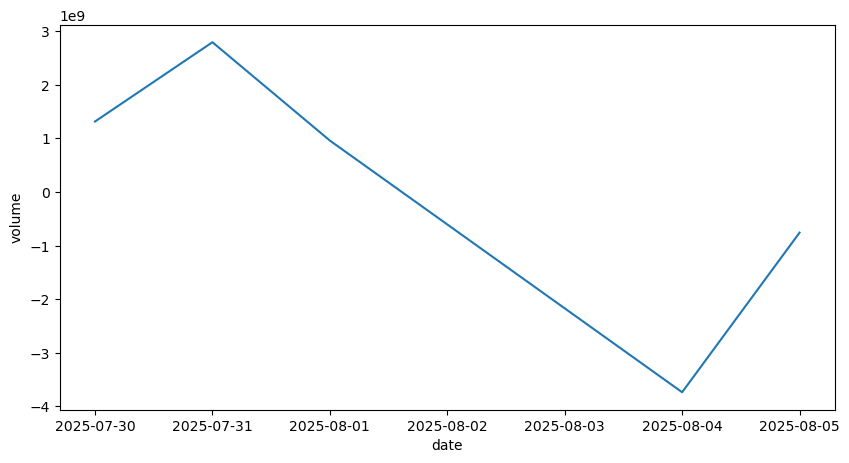

In [ ]:
# 再加上 pandas 的 dataframe 來把多天資料整合在一起並做成折線圖

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.support.ui import Select
from datetime import date , timedelta
import os
import csv
import pandas
import matplotlib.pyplot as matplot

driver = webdriver.Chrome()

driver.get("https://www.twse.com.tw/zh/trading/foreign/bfi82u.html")

# 選擇日期的函數

def select_date(date) : 

    select = driver.find_element(By.CLASS_NAME,"selects")

    selects = select.find_elements(By.TAG_NAME,"select")

    year_select = Select(selects[0])
        
    year_select.select_by_value(str(date.year))

    month_select = Select(selects[1])

    month_select.select_by_value(str(date.month))

    day_select = Select(selects[2])

    day_select.select_by_value(str(date.day))

    submit = driver.find_element(By.CLASS_NAME,"submit")

    search = submit.find_element(By.CLASS_NAME,"search")

    search.click()

# 抓取資料的函數

def fetch_data() :

    data = []

    try : 

        wait = WebDriverWait(driver,5)
        wait.until(expected_conditions.visibility_of_element_located((By.TAG_NAME,"table")))

        content = driver.find_element(By.TAG_NAME,"table")

        rows = content.find_elements(By.TAG_NAME,"tr")

        for row in rows : 

            th_rows = row.find_elements(By.TAG_NAME,"th")

            if th_rows : 

                th_row = []

                th_row = [th_cell.text for th_cell in th_rows]

                data.append(th_row)

            td_rows = row.find_elements(By.TAG_NAME,"td")

            if td_rows : 

                td_row = []

                td_row = [td_cell.text for td_cell in td_rows]

                data.append(td_row)

        return data

    except : 

        return data

# 儲存資料的函數

def save_data(path,day,download) : 

    with open(path + f"/{day.year}{day.month:02d}{day.day:02d}.csv","w",encoding="utf-8-sig",newline="") as file : 

        writer = csv.writer(file)

        writer.writerows(download)

# 下載一系列資料的函數

def download_series(Ndays,input_day) :

    N = Ndays

    download_time = 0

    while download_time < N : 

        if input_day.weekday() < 5 : 

            select_date(input_day)

            result = fetch_data()

            if result == [] :

                break
            
            save_data(download_path,input_day,result)

            download_time += 1

        input_day = input_day - timedelta(days=1)

# 執行下載

assign_day = date.today()

download_path = f"download_{assign_day.year}{assign_day.month:02d}{assign_day.day:02d}"

os.makedirs(download_path, exist_ok=True)

download_series(5,assign_day)

# 讀取下載檔案

files = os.listdir(download_path)

all_data = []

for file in files : 

    dataframe = pandas.read_csv(download_path + "/" + file)

    dataframe = dataframe[["單位名稱","買賣差額"]]

    dataframe["日期"] = file.split(".")[0]

    all_data.append(dataframe)

print(all_data)

# 把資料合併

combine = pandas.concat(all_data)

# 再把資料調整成適合的型別

combine["日期"] = pandas.to_datetime(combine["日期"])
combine["買賣差額"] = pandas.to_numeric(combine["買賣差額"].str.replace(",","",regex=False))

plot = combine[combine["單位名稱"]=="自營商(自行買賣)"]

# 畫圖

matplot.figure(figsize=(10,5))
matplot.plot(plot["日期"],plot["買賣差額"])
matplot.xlabel("date")
matplot.ylabel("volume")
matplot.show()



In [ ]:
import os
import pandas
import matplotlib.pyplot as matplot

# 把每一筆資料讀進來後合併

file_set = os.listdir("download")

all_file = []

for file in file_set : 

    # pandas.read_csv 可以用 skiprow 搭配 nrow 選擇要選中間哪幾行

    dataframe = pandas.read_csv("download/"+file,encoding="big5",skiprows=1,nrows=4)

    # 會用 dataframe[ [ "..." , "..." ] ] 這樣架構是因為是 list of list , 資料是分成很多份 , 所以是 [ [ 第一個檔案 ] , [ 第二個檔案 ] ] , 
    # 所以會用 [] 再包住兩個欄位，表示選取各個資料的特定欄位

    new_dataframe = dataframe[["單位名稱","買賣差額"]]

    # split 是依照條件把檔名分割的方法，這邊就是把 "20250801.csv" 拆成 "20250801" , "csv" 再選擇第一個

    new_dataframe["日期"] = file.split(".")[0]

    all_file.append(new_dataframe)

# 把資料合成 dataframe 並作欄位和欄位資料型別調整

combine = pandas.concat(all_file)

# pandas.to_numeric 只認一般格式的數字 , 不會認有逗號的格式 , 因此要用 .string.replace 來把逗號拿掉

combine["日期"] = pandas.to_datetime(combine["日期"])
combine["買賣差額"] = pandas.to_numeric(combine["買賣差額"].str.replace(",","",regex=False))
combine.dropna(subset=["買賣差額"])

plot = combine[combine["單位名稱"]=="投信"].sort_values("日期")

# 畫圖

matplot.figure(figsize=(10,5))
matplot.plot(plot["日期"],plot["買賣差額"])
matplot.xlabel("日期")
matplot.ylabel("買賣差額")
matplot.show()